In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from typing import Dict, List
from PIL import Image
from io import StringIO,BytesIO 
from scipy.spatial.distance import pdist
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize,normalize
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.ndimage import zoom
from functools import reduce
from scipy.io import loadmat
from skimage.measure import block_reduce
from collections import Counter
from scipy.sparse import coo_matrix,hstack, vstack
import cv2
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.ops as ops
torch.cuda.set_device(7)
print (torch.cuda.current_device())

Loading faiss with AVX2 support.


7


In [2]:
tstart = time.time()
root_dir = '/data/fjsdata/MCBIR-Ins/origa650/' #the path of images
trData = pd.read_csv(root_dir+"trainset.csv" , sep=',')
teData = pd.read_csv(root_dir+"testset.csv" , sep=',')
#trainset 
trN, trI, trM, trY = [],[],[],[]
for iname, itype in np.array(trData).tolist():
    iname=os.path.splitext(iname)[0].strip()[1:] #get rid of file extension
    try:
        trN.append(iname)
        if itype==True: #glaucoma
            trY.append(1)
        else: trY.append(0) #False
        image_path = os.path.join(root_dir, 'images', iname+'.jpg')
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        trI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname+'.mat')
        mask = cv2.resize(loadmat(mask_path)['mask'],(256, 256))#(256,256)
        trM.append(mask)
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(trN),trData.shape[0]))
    sys.stdout.flush()
print('The length of trainset is %d'%len(trN))
#testset
teN, teI, teM, teY = [],[],[],[]
for iname, itype in np.array(teData).tolist():
    iname=os.path.splitext(iname)[0].strip()[1:] #get rid of file extension
    try:
        teN.append(iname)
        if itype==True: #glaucoma
            teY.append(1)
        else: teY.append(0) #False
        image_path = os.path.join(root_dir, 'images', iname+'.jpg')
        img = cv2.resize(cv2.imread(image_path).astype(np.float32), (256, 256))#(256,256,3)
        teI.append(img)
        mask_path = os.path.join(root_dir,'mask', iname+'.mat')
        mask = cv2.resize(loadmat(mask_path)['mask'],(256, 256))#(256,256)
        teM.append(mask)
    except:
        print(iname+":"+str(image_path))
    sys.stdout.write('\r{} / {} '.format(len(teN),teData.shape[0]))
    sys.stdout.flush()
print('The length of testset is %d'%len(teN))

elapsed = time.time() - tstart
print('Completed data handle in %d seconds' % int(elapsed))

585 / 585 The length of trainset is 585
65 / 65 The length of testset is 65
Completed data handle in 103 seconds


In [5]:
#Baseline: DRH-MICCAI2017《Hashing with Residual Networks for Image Retrieval》
#https://github.com/dansuh17/deep-supervised-hashing
class ResBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=out_channels,
                kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.downsample_layer = None
        self.do_downsample = False
        if in_channels != out_channels or stride != 1:
            self.do_downsample = True
            self.downsample_layer = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        identity = x
        out = self.net(x)

        if self.do_downsample:
            identity = self.downsample_layer(x)

        return F.relu(out + identity, inplace=True)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class ResNet(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            ResBlock(in_channels=3, out_channels=16),
            ResBlock(in_channels=16, out_channels=16),
            ResBlock(in_channels=16, out_channels=16, stride=2),
        )
        self.linear_input_size = 16*128*128
        self.linear = nn.Linear(self.linear_input_size, num_classes)

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        x = self.net(x)
        x = x.view(-1, self.linear_input_size)
        return self.linear(x)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            
class DRH(nn.Module):
    def __init__(self, code_size: int):
        super().__init__()
        resnet = ResNet(num_classes=10)
        resnet.linear = nn.Linear(in_features=resnet.linear_input_size, out_features=code_size)
        self.net = resnet

        # initialize weights
        self.apply(self.init_weights)

    def forward(self, x):
        return self.net(x)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

class HashLossFunc(nn.Module):
    def __init__(self, margin=0.5, alpha=0.01):
        super(HashLossFunc, self).__init__()
        self.alpha = alpha #regularization
        self.margin = margin #margin threshold
        self.mse_loss = nn.MSELoss(reduction='none')
        self.l1_loss = nn.L1Loss(reduction='mean')
    
    def forward(self,h1,h2,y):    
        margin_val = self.margin * h1.shape[1]
        squared_loss = torch.mean(self.mse_loss(h1, h2), dim=1)
        # T1: 0.5 * (1 - y) * dist(x1, x2)
        positive_pair_loss = (0.5 * (1 - y) * squared_loss)
        mean_positive_pair_loss = torch.mean(positive_pair_loss)
        # T2: 0.5 * y * max(margin - dist(x1, x2), 0)
        zeros = torch.zeros_like(squared_loss)
        marginMat = margin_val * torch.ones_like(squared_loss)
        negative_pair_loss = 0.5 * y * torch.max(zeros, marginMat - squared_loss)
        mean_negative_pair_loss = torch.mean(negative_pair_loss)

        # T3: alpha(dst_l1(abs(x1), 1)) + dist_l1(abs(x2), 1)))
        mean_value_regularization = self.alpha * (
                self.l1_loss(torch.abs(h1), torch.ones_like(h1)) +
                self.l1_loss(torch.abs(h2), torch.ones_like(h2)))

        loss = mean_positive_pair_loss + mean_negative_pair_loss + mean_value_regularization
        return loss

#Generate image pairs for model
def onlineGenImgPairs():
    if (len(trY) % 2) == 0: spls = len(trY)
    else:  spls = len(trY)-1
    idx_sf = random.sample(range(0, spls),spls)
    trI1_sf, trI2_sf, trY1_sf, trY2_sf = [],[],[],[]
    flag = 0
    for i in idx_sf:
        if flag==0:
            trI1_sf.append(trI[i])
            trY1_sf.append(trY[i])
            flag =1
        else:
            trI2_sf.append(trI[i])
            trY2_sf.append(trY[i])
            flag =0
    trY_sf = np.where((np.array(trY1_sf)-np.array(trY2_sf))!=0,1,0)
    return np.array(trI1_sf),np.array(trI2_sf),trY_sf

#define model
model = DRH(code_size=36).cuda()
criterion  = HashLossFunc(margin=0.5).cuda() #define loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #define optimizer
#train model
best_net, best_loss = None, float('inf')
batchSize = 10
trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
num_batches = len(trY_sf) // batchSize 
for epoch in range(10):#iteration
    trI1_sf, trI2_sf, trY_sf = onlineGenImgPairs()
    losses = []
    for i in range(num_batches):
        optimizer.zero_grad()#grad vanish
        min_idx = i * batchSize
        max_idx = np.min([len(trY_sf), (i+1)*batchSize])
        I1_batch = torch.from_numpy(trI1_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        I2_batch = torch.from_numpy(trI2_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        Y_batch = torch.from_numpy(trY_sf[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        #forword
        X1_batch = model(I1_batch.permute(0, 3, 1, 2))#permute the dims of matrix
        X2_batch = model(I2_batch.permute(0, 3, 1, 2))
        #binary-like loss
        loss = criterion(X1_batch,X2_batch,Y_batch)
        #backward
        loss.backward()
        #update parameters
        optimizer.step()
        #show loss
        sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
        sys.stdout.flush()     
        losses.append(loss.item())
    print("Eopch: %5d mean_loss = %.6f" % (epoch + 1, np.mean(losses)))
    if np.mean(losses) < best_loss:
        best_loss = np.mean(losses)
        best_net = copy.deepcopy(model)
print("best_loss = %.6f" % (best_loss))
#release gpu memory
model = model.cpu()
criterion = criterion.cpu()
I1_batch = I1_batch.cpu()
I2_batch = I2_batch.cpu()
Y_batch = Y_batch.cpu()
torch.cuda.empty_cache()

#hash code of train data from model
#torch.cuda.synchronize()
batchSize = 10
num_batches = len(trI) // batchSize + 1
trF = []
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(trI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(trI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    trF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
#hash code of test data from model
#torch.cuda.synchronize()
teF = []
num_batches = len(teI) // batchSize+1
for i in range(num_batches):
    min_idx = i * batchSize
    max_idx = np.min([len(teI), (i+1)*batchSize])
    I_batch = torch.from_numpy(np.array(teI[min_idx: max_idx])).type(torch.FloatTensor).cuda()
    X_batch = best_net(I_batch.permute(0, 3, 1, 2))#forword
    I_batch = I_batch.cpu()
    X_batch = X_batch.cpu()
    torch.cuda.empty_cache()#release gpu memory
    teF.extend(X_batch.data.numpy().tolist())
    sys.stdout.write('\r {} / {} '.format(i, num_batches))
    sys.stdout.flush()
    
#evaluate
#compute the size of lesion
def Func_IOU_size(pred,target,n_classes = 3 ):
    ious = []
    # ignore IOU for background class
    for cls in range(1,n_classes):
        pred_inds = pred == cls
        pred_sum = pred_inds.sum()
        target_inds = target == cls
        target_sum = target_inds.sum()
        ious.append(round(float(min(pred_sum,target_sum)/max(pred_sum,target_sum)),4))
    return np.mean(ious)
# buliding index of trainset
tstart = time.time()
cpu_index = faiss.IndexFlatL2(36) #
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index) #make all gpu usable
gpu_index.add(np.ascontiguousarray(trF, dtype=np.float32)) #add data(must be float32) to index
elapsed = time.time() - tstart    
print('Completed buliding index in %d seconds' % int(elapsed))
for topk in [5, 10, 20, 50]:
    mAP = [] #mean average precision
    mIoU = []
    scores, neighbors = gpu_index.search(np.array(teF).astype('float32'), k=topk)
    for i, teVal in enumerate(teF):
        stype = teY[i]
        #perfromance
        pos_len = 0
        rank_len = 0
        #for j in ranklist:
        for j in neighbors[i].tolist():
            dtype = trY[j]
            rank_len=rank_len+1
            if stype==dtype:  #hit
                pos_len = pos_len +1
                mAP.append(pos_len/rank_len) 
            else: 
                mAP.append(0)
            mIoU.append(Func_IOU_size(teM[i],trM[j]))
    print("mAP={:.4f}, mIoU={:.4f}".format(np.mean(mAP),np.mean(mIoU)))

 29 / 29 : loss = 6.9853913Eopch:     1 mean_loss = 12.836882
 29 / 29 : loss = 4.488482Eopch:     2 mean_loss = 5.396898
 29 / 29 : loss = 5.806445Eopch:     3 mean_loss = 4.641309
 29 / 29 : loss = 3.442748Eopch:     4 mean_loss = 4.103210
 29 / 29 : loss = 4.217492Eopch:     5 mean_loss = 4.618119
 29 / 29 : loss = 2.934872Eopch:     6 mean_loss = 4.077280
 29 / 29 : loss = 3.347312Eopch:     7 mean_loss = 3.807517
 29 / 29 : loss = 4.742602Eopch:     8 mean_loss = 4.196169
 29 / 29 : loss = 4.357125Eopch:     9 mean_loss = 3.841332
 29 / 29 : loss = 4.768262Eopch:    10 mean_loss = 3.668660
best_loss = 3.668660
 6 / 7 9 Completed buliding index in 24 seconds
mAP=0.6468, mIoU=0.7239
mAP=0.6124, mIoU=0.7218
mAP=0.5805, mIoU=0.7198
mAP=0.5538, mIoU=0.7191


In [6]:
#release gpu memory
model = model.cpu()
criterion = criterion.cpu()
I1_batch = I1_batch.cpu()
I2_batch = I2_batch.cpu()
Y_batch = Y_batch.cpu()
torch.cuda.empty_cache()

In [7]:
image_path_top = []
for i in [39]:#[5, 10,15,31,39]:#range(len(trY)):
    itype = trY[i]
    teVal = trF[i]
    image_path = os.path.join(root_dir, 'images', trN[i])
    map_item_score = {}
    scores, neighbors = gpu_index.search(np.array(trF[i:i+1]).astype('float32'), k=6)
    for j in neighbors[0].tolist():
        print ('pos: %d-itype:%d-dtype:%d'%(i,trY[i],trY[j]))
        image_path_top.append(trN[j])
print(image_path_top)

pos: 39-itype:1-dtype:1
pos: 39-itype:1-dtype:0
pos: 39-itype:1-dtype:0
pos: 39-itype:1-dtype:1
pos: 39-itype:1-dtype:0
pos: 39-itype:1-dtype:1
['429', '403', '346', '270', '183', '228']


(256, 256)


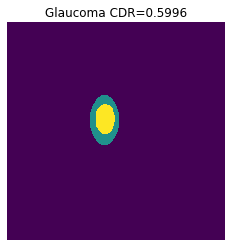

In [14]:
mask = loadmat('/data/fjsdata/MCBIR-Ins/origa650/mask/228.mat')['mask']
mask = cv2.resize(mask,(256, 256))
print (mask.shape)
#print(Counter(mask.flatten()))
imgplot = plt.imshow(mask)
plt.title('Glaucoma CDR=0.5996' )#Glaucoma, Normal
plt.axis('off')
plt.show()